In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm, tqdm_notebook
from scipy import stats

import glob
import os

Здравствуйте, коллеги. Рассмотрим обычный онлайн эксперимент в некоторой компании "Усы и когти". У них есть веб сайт, на котором есть красная кнопка, в форме прямоугольника с закругленными краями. Если пользователь нажимает на эту кнопку, то где то в мире мурлычет от радости один котенок. Задача компании максимизация мырлыкания. Так же есть отдел маркетинга, который усердно исследует формы кнопок и то, как они влияют конверсию. Потратив почти весь бюджет компании на уникальные исследования, маркетинг разделился на четыре противоборствующие группировоки. У каждой группировки есть своя гениальная идея того, как должна выглядеть кнопка. В целом никто не против формы кнопки, но красный раздражает всех маркетологов, и было предложенно четыре альтернативных варианта. На самом деле не так важно даже какие варианты, нас интересует тот вариант, который максимизирует мырлыкания. Маркетинг предлагает провести A/B/n тест, но мы не согласны, и так на эти сомнительные исследования спущено денег немеренно. Попробуем осчастливить как можно больше котят и сэкономить на трафике. Для оптимизации трафика, пущенного на тесты, мы будет использовать шайку многоруких байесовских бандитов (bayesian multi-armed bandits). Вперед.

# A/B/n тест

Будем считать, что конверсия - это некоторая случайная переменная $k$, принимающая значения  $0$ или $1$, с вероятностью $\theta$ и $1 - \theta$ соответственно. Такая величина имеет распределение Бернулли с параметром $\theta$:

$$\large 
\begin{array}{rcl}
k &\sim& \text{Bernoulli}\left(\theta\right) \\
p\left(k = 1\right) &=& \theta^k \left(1 - \theta\right)^{1 - k}
\end{array}
$$

Вспомним, что среднее значение распределения Бернулли равно $\mu = \theta$, а дисперсия равна $\sigma^2 = \theta\left(1 - \theta\right)$.

Попробуем для начала решить проблему с помощью обычного A/B/n теста, n здесь означает, что тестируются не две гипотезы, а несколько. В нашем случае это пять гипотез. Но мы рассмотрим сначала ситуацию тестирования старого решения против нового, а затем обобщим на все пять случаев. В бинарном случае у нас есть две гипотезы:
- нулевая гипотеза $H_0: \theta_c = \theta_t$ заключается в том, что нет никакой разницы в вероятностью клика по старой кнопке $\theta_c$ и или по новой $\theta_t$;
- альтернативная гипотеза $H_1: \theta_c < \theta_t$ заключается в том, что вероятностью клика по старой кнопке $\theta_c$ именьше чем по новой $\theta_t$;
- вероятности $\theta_c$ и $\theta_t$ мы оцениваем как отношение кликов к показам на контролькой группе (control) и экспериментальной/тестовой группе (treatment) соответственно.

Мы не можем знать истинное значение конверсии $\theta_c$ на текущей вариации кнопки (на красной), но мы можем его оценить. Для этого у нас есть два механизма, которые работаю сообща. Во-первых, <a href="https://ru.wikipedia.org/wiki/Закон_больших_чисел">закон больших чисел</a>, который утверждает, что какое бы не было распределение случайной величины, если мы посемплируем достаточное количество примеров и усредним, то такая оценка будет близка к истинному значению среднеднего значения распределения (опустим пока индекс $c$ для ясности):

$$\large
\begin{array}{rcl}
\overline{\theta}_n &=& \frac{1}{n}\sum_{i=1}^n k_i \\
\forall \epsilon \in \mathbb{R}: \lim_{n \rightarrow \infty} &=& P\left(\left|\overline{\theta}_n - \mu\right| < \epsilon\right) = 1
\end{array}
$$

Во-вторых, <a href="https://ru.wikipedia.org/wiki/Центральная_предельная_теорема">центральная предельная теорема</a>, которая утверждает следующее. Допустим есть бесконечный ряд независимых и одинаково распределенных случайных величин $k_1, k_2, \ldots$, с истинным матожиданием $\mu$ и дисперсией $\sigma^2$. Обозначим конечную сумму как $S_n = \sum_{i}^n k_i$, тогда

$$\large
\frac{S_n - \mu}{\sigma\sqrt{n}} \rightarrow \mathcal{N}\left(0, 1\right)\text{ при }n \rightarrow \infty
$$

или эквивалентно, тому, что при достаточно больших выборках оценка среднего значения имеет нормальное распределение с ментром в $\mu$ и дисперсией $\frac{\sigma^2}{n}$:

$$\large
\overline{\theta} \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{n}\right)
$$

Казалось бы бери да запускай два теста: раздели трафик на две части, жди пару дней, и сравнивай средние значения кликов по первому механизму. Второй механизм позволяет нам применять <a href="https://ru.wikipedia.org/wiki/T-Критерий_Стьюдента">t-тест</a> для оценки статистической значимости разницы средних значений выборок (потому что оценки средних имеют нормальное распределение). Но остается один важный вопрос: а какое количество трафика (пользователей) пустить на каждуй вариацию кнопки. Статистика нам говорит, что если разница не нулевая, то это еще совсем не значит, что значения не равны. Возможно не повезло просто и первые $70\%$ пользователей люто ненавидели какой то цвет, и нужно подождать еще. И возникает вопрос, а сколько пользователей пустить на каждую вариацию кнопки, что бы быть уверенным, что если разница и есть, то она существенная. Для этого нам придется еще раз встретиться с отделом маркетинга, и задать им несколько вопросов, и вероятно нам придется им объяснить, что такое ошибки первого и второго рода. В общем это может быть чуть ли не самым сложным во всем тесте. Итак, вспомним, что это за ошибки, и определим вопросы, которые следует задать отделу маркетинга, что бы оценить количество трафика на вариацию. В конечном счете именно маркетинг принимает окончательно решение о том, какой цвет кнопки оставить. 

<table>
<tr><td colspan=2 rowspan=2></td><td colspan=2>Верная гипотеза</td></tr>
<tr><td>$H_0$</td><td>$H_1$</td></tr>
<tr>
    <td rowspan=2>Ответ теста</td>
    <td>$H_0$</td>
    <td bgcolor="lightgreen">$H_0$ принята</td>
    <td bgcolor="LightCoral">$H_0$ неверно принята <br/> (ошибка II рода)</td>
</tr>
<tr>
    <td>$H_1$</td>
    <td bgcolor="LightCoral">$H_0$ неверно отвергнута <br/> (ошибка I рода)</td>
    <td bgcolor="lightgreen">$H_0$ отвергнута</td>
</tr>
</table>

Введем еще несколько понятий. Обозначим вероятность ошибки первого рода как $\alpha = P\left(H_1 \mid H_0\right)$, т.е. вероятность принятия альтернативной гипотезы, при условии, что на самом деле верна нулевая гипотеза. Эта величина называется статистической значимостью (statistical significance). Так же нам понадобидся ввести вероятность ошибки второго рода $\beta = P\left(H_0 \mid H_1\right)$. Величина $1 - \beta$ называется статистической мощностью (statistical power). 

Рассмотрим изображени ниже, что бы проиллюстрировать смысл статистической значимости и мощности. Предположим, что среднее значение распределения случайной величины на контрольной группе равно $\mu_c$, а на тестовой $\mu_t$. Выберем некоторый критический порог выше которого гипотеза $H_0$ отвергается (вертикальная зеленая линия). Тогда, если значение было правее порога, то из распределения контрольной группы, то мы его ошибочно припишем к распределению тестовой группы. Это будет ошибка первого рода, а значение $\alpha$ это прощадь акрашенная красным цветом. Соответственно, область закрашенная синим цветом равна $\beta$. Величина $1 - \beta$, которую мы назвали статистической мощностью, по сути это то, сколько значений соответствующих альтернативной гипотезе мы действительно отнесем к альтернативной гипотезе.

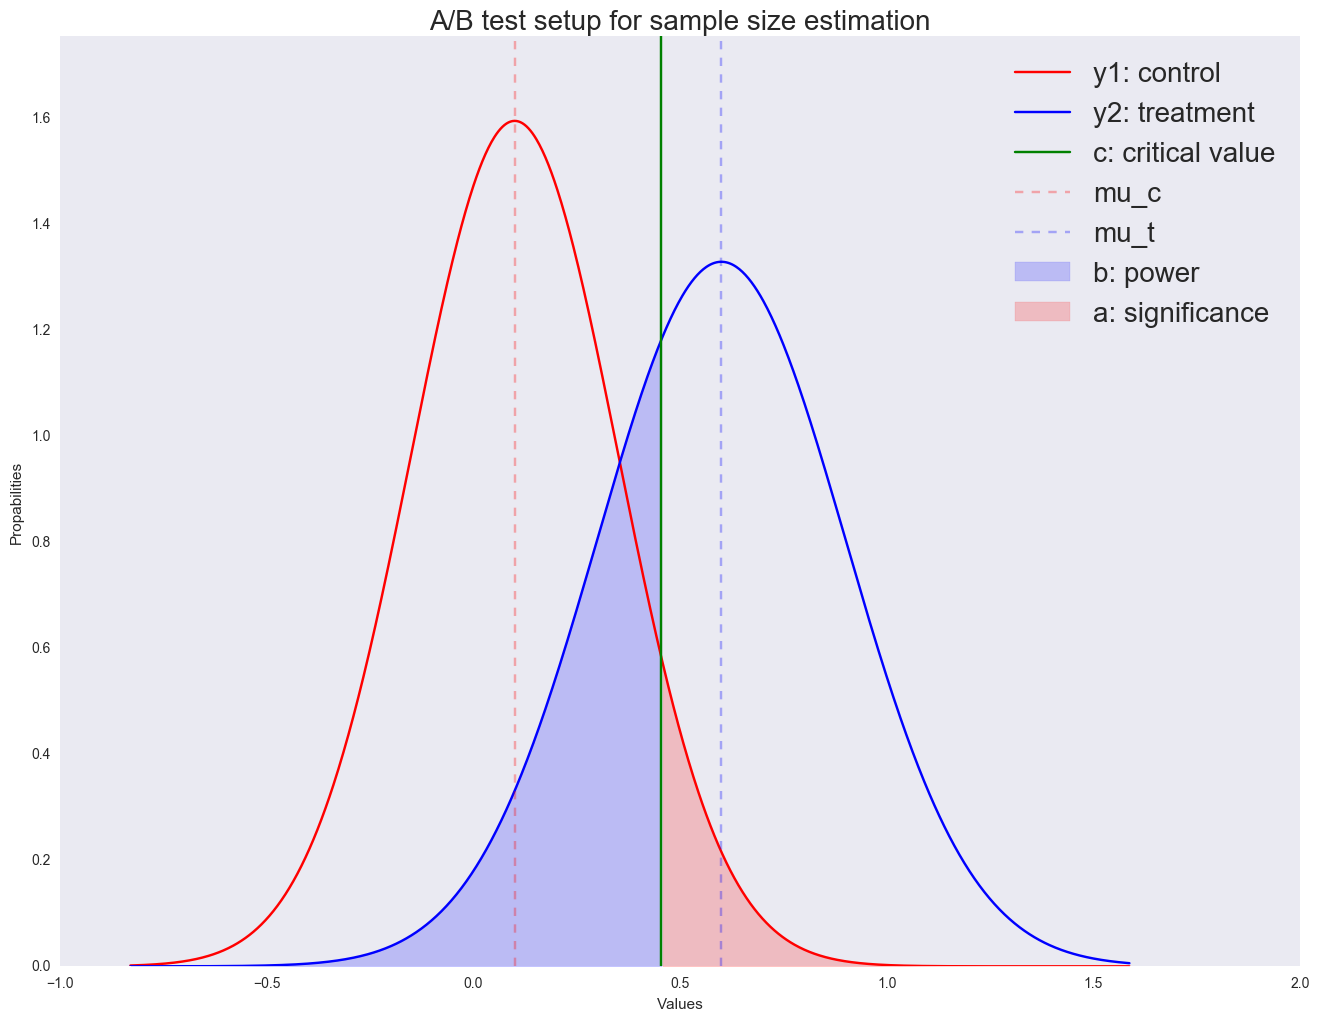

In [2]:
mu_c = 0.1
mu_t = 0.6
s_c = 0.25
s_t = 0.3
c = 1.3*(mu_c + mu_t)/2

support = np.linspace(
    stats.norm.ppf(0.0001, loc=mu_c, scale=s_c), 
    stats.norm.ppf(1 - 0.0005, loc=mu_t, scale=s_t), 1000)
y1 = stats.norm.pdf(support, loc=mu_c, scale=s_c)
y2 = stats.norm.pdf(support, loc=mu_t, scale=s_t)

fig, ax = plt.subplots()
ax.plot(support, y1, color='r', label='y1: control')
ax.plot(support, y2, color='b', label='y2: treatment')
ax.set_ylim(0, 1.1*np.max([
            stats.norm.pdf(mu_c, loc=mu_c, scale=s_c),
            stats.norm.pdf(mu_t, loc=mu_t, scale=s_t)
        ]))
ax.axvline(c, color='g', label='c: critical value')
ax.axvline(mu_c, color='r', alpha=0.3, linestyle='--', label='mu_c')
ax.axvline(mu_t, color='b', alpha=0.3, linestyle='--', label='mu_t')
ax.fill_between(support[support <= c], 
                y2[support <= c], 
                color='b', alpha=0.2, label='b: power')
ax.fill_between(support[support >= c], 
                y1[support >= c], 
                color='r', alpha=0.2, label='a: significance')

ax.legend(loc='upper right', prop={'size': 20})
ax.set_title('A/B test setup for sample size estimation', fontsize=20)
ax.set_xlabel('Values')
ax.set_ylabel('Propabilities')

plt.show()

Обозначим этот порог буквой $c$, то справедливо следующее равенствно, при условии, что случайная величина имеет нормальное распределение:

$$\large
c = \mu + t\frac{\sigma}{\sqrt{n}}
$$
где $t = P\left(X \leq t\right), X \sim \mathcal{N}\left(0, 1\right)$ - это <a href="https://ru.wikipedia.org/wiki/Функция_ошибок">квантильная функция</a>.

В нашем случае мы можем записать систему из двух уравнений для $\alpha$ и $\beta$ соответственно:

$$\large
\begin{array}{rcl}
c &=& \theta_c + t_{\alpha}\sqrt{\frac{\theta_c\left(1 - \theta_c\right)}{n}} \\
c &=& \theta_t + t_{\beta}\sqrt{\frac{\theta_t\left(1 - \theta_t\right)}{n}}
\end{array}
$$

Решив эту систему относительно $n$ мы получим оценку достаточного количества трафика, который необходимо загнать в каждый эксперимент при заданной статистической значимости и мощности. 

$$\large
\begin{array}{rcl}
\theta_c + t_{\alpha}\sqrt{\frac{\theta_c\left(1 - \theta_c\right)}{n}} &=& \theta_t + t_{\beta}\sqrt{\frac{\theta_t\left(1 - \theta_t\right)}{n}} \\
\theta_c \sqrt{n} + t_{\alpha}\sqrt{\theta_c\left(1 - \theta_c\right)} &=& \theta_t \sqrt{n} + t_{\beta}\sqrt{\theta_t\left(1 - \theta_t\right)} \\
n &=& \left(\frac{t_{\beta}\sqrt{\theta_t\left(1 - \theta_t\right)} - t_{\alpha}\sqrt{\theta_c\left(1 - \theta_c\right)}}{\theta_c - \theta_t}\right)^2
\end{array}
$$

Таким образом, что бы вычислить эффективный размер выборки, мы должны пойти в маркетинг или другой бизнес департамент и узнать у них следующее:
- какое значение конверсии $\theta_t$ на новой вариации должно получиться, что бы бизнес принял решение перейти со старой версии кнопки с конверсией $\theta_c$ на новую;
- какой допустимый уровень значимости $\alpha$ и мощности $\beta$ необходим (вероятно тут еще придется как то объяснить бизнесу что это значит).

Получив $n$ мы можем легко вычислить порог $c$. Это значит, что если мы соберем $n$ наблюдейний для каждой вариации, и окажется, что в экспериментальной группе оценка клика $theta_t$ выше порога $c$, то мы отклняем $H_0$ и принимаем альтернативную гипотезу $H_1$, о том что новая вариация лучше и вероятно мы ее внедрим. В этом случае у нас будет $\alpha \cdot 100\%$ шансов ошибки первого рода, т.е. мы ошибочно приняли решение заменить старую кнопку на новую. 

So, in summary, if the pollster collects data on n = 1001 voters, and rejects his null hypothesis H0: p = 0.50 if the proportion of sampled voters who favor the political candidate is greater than 0.5367, he will have a 1% chance of committing a Type I error and a 20% chance of committing a Type II error if the population proportion p were actually 0.55.

In [8]:
np.random.seed(1342)

p_c = 0.3 
p_t = 0.4
alpha = 0.05
beta = 0.2
t_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
t_beta = stats.norm.ppf(beta, loc=0, scale=1)

def get_size(theta_c, theta_t, alpha, beta):
    n = t_alpha*np.sqrt(theta_t*(1 - theta_t))
    n -= t_beta*np.sqrt(theta_c*(1 - theta_c))
    n /= theta_c - theta_t
    return int(np.ceil(n*n))

n_max = get_size(p_c, p_t, alpha, beta)
c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*np.sqrt(p_c*(1 - p_c)/n_max)
print n_max, c

n_list = range(5, n_max, 1) + [n_max]
for f in glob.glob("./../images/sample_size_gif/*.*"):
    os.remove(f)
for n in tqdm_notebook(n_list):
    s_c = np.sqrt(p_c*(1 - p_c)/n)
    s_t = np.sqrt(p_t*(1 - p_t)/n)

    c_c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*s_c
    c_t = p_t + stats.norm.ppf(beta, loc=0, scale=1)*s_t

    support = np.linspace(0, 1, 1000)
    y_c = stats.norm.pdf(support, loc=p_c, scale=s_c)
    y_t = stats.norm.pdf(support, loc=p_t, scale=s_t)
    y_c /= max(y_c.max(), y_t.max())
    y_t /= max(y_c.max(), y_t.max())


    fig, ax = plt.subplots()
    ax.plot(support, y_c, color='r', label='y control')
    ax.plot(support, y_t, color='b', label='y treatment')

    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, 1)

    ax.axvline(c, color='g', label='c')
    ax.axvline(c_c, color='m', label='c_c')
    ax.axvline(c_t, color='c', label='c_p')
    ax.axvline(p_c, color='r', alpha=0.3, linestyle='--', label='p_c')
    ax.axvline(p_t, color='b', alpha=0.3, linestyle='--', label='p_t')

    ax.fill_between(support[support <= c_t], 
                    y_t[support <= c_t], 
                    color='b', alpha=0.2, label='b: power')
    ax.fill_between(support[support >= c_c], 
                    y_c[support >= c_c], 
                    color='r', alpha=0.2, label='a: significance')

    ax.legend(loc='upper right', prop={'size': 20})
    
    ax.set_title('Sample size: %i' % n, fontsize=20)

    fig.savefig('./../images/sample_size_gif/%i.png' % n, dpi=80)
    plt.close(fig)

142 0.363254690043



In [9]:
!convert -delay 5 $(for i in $(seq 5 1 142); do echo ./../images/sample_size_gif/${i}.png; done) -loop 0 ./../images/sample_size_gif/sample_size.gif

<img src="./../images/sample_size_gif/sample_size.gif" />

- не забыть добавить про то что м пользуем заведомо хуевый варик
- нужно всунуть про закон больших чисел и про ЦПТ
- дисперсия обычная это дисперсия семпла, а SE это дисперсия среднего